b) Läs in 10 bilder slumpmässigt, plotta dem och extrahera deras labels och skriv ut i titeln.

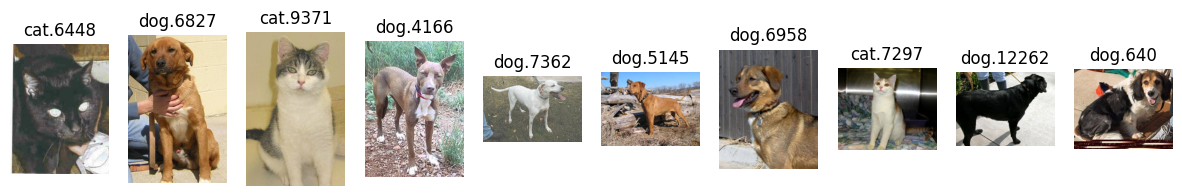

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random

current_path = Path().absolute()
train_path = current_path / "original_data" / "train"

train_list = list(train_path.iterdir())

num_images_to_sample = min(10, len(train_list))

if num_images_to_sample > 0:
    pictures = random.sample(train_list, num_images_to_sample)

    labels = [path.stem.split('_')[0] for path in pictures]

    fig, axes = plt.subplots(1, num_images_to_sample, figsize=(15, 3))
    if num_images_to_sample > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    for ax, img_path, label in zip(axes, pictures, labels):
        image = plt.imread(img_path)
        ax.imshow(image)
        ax.set_title(label)
        ax.axis("off")

    plt.show()



In [36]:
"""

# Definiera de olika sökvägarna
experiment_small_data = Path("experiment_small_data")
experiment_tiny_data = Path("experiment_tiny_data")
original_data = Path("original_data")


# Skapa mappstrukturen
experiment_small_data.mkdir(parents=True, exist_ok=True)
experiment_tiny_data.mkdir(parents=True, exist_ok=True)
(original_data / "test").mkdir(parents=True, exist_ok=True)
(original_data / "train").mkdir(parents=True, exist_ok=True)

#Skapa undermappar i experiment_small_data och experiment_tiny_data
for folder in ["test", "train", "val"]:
    (experiment_small_data / folder).mkdir(exist_ok=True)
    (experiment_tiny_data / folder).mkdir(exist_ok=True)

# bugtest så vi vet om något går fel
for item in Path(".").rglob("*"):
     print(item) 

"""

'\n\n# Definiera de olika sökvägarna\nexperiment_small_data = Path("experiment_small_data")\nexperiment_tiny_data = Path("experiment_tiny_data")\noriginal_data = Path("original_data")\n\n\n# Skapa mappstrukturen\nexperiment_small_data.mkdir(parents=True, exist_ok=True)\nexperiment_tiny_data.mkdir(parents=True, exist_ok=True)\n(original_data / "test").mkdir(parents=True, exist_ok=True)\n(original_data / "train").mkdir(parents=True, exist_ok=True)\n\n#Skapa undermappar i experiment_small_data och experiment_tiny_data\nfor folder in ["test", "train", "val"]:\n    (experiment_small_data / folder).mkdir(exist_ok=True)\n    (experiment_tiny_data / folder).mkdir(exist_ok=True)\n\n# bugtest så vi vet om något går fel\nfor item in Path(".").rglob("*"):\n     print(item) \n\n'

d) Nu ska du göra train|val|test split med följande splits:

experiment_small
* train - 1600 (800 dogs, 800 cats)
* val - 400 (200 dogs, 200 cats)
* test - 500 (250 dogs, 250 cats)

experiment_tiny (BONUS)
* train - 160 (80 dogs, 80 cats)
* val - 40 (20 dogs, 20 cats)
* test - 50 (25 dogs, 25 cats

In [37]:
import shutil

current_path = Path().absolute()
original_data = current_path / "original_data" / "train"
experiment_small_data = current_path / "experiment_small_data"
experiment_tiny_data = current_path / "experiment_tiny_data"

splits_info = {
    "experiment_small": {"train": 1600, "val": 400, "test": 500},
    "experiment_tiny": {"train": 160, "val": 40, "test": 50}
}

def setup_datasets(experiment_path, splits, source_data):
    experiment_path.mkdir(parents=True, exist_ok=True)

    images = list(source_data.glob("*.jpg"))
    random.shuffle(images)  

    for split_name, total_images in splits.items():
        split_path = experiment_path / split_name
        split_path.mkdir(parents=True, exist_ok=True)

        existing_images = list(split_path.glob("*.jpg"))
        num_existing = len(existing_images)
        num_needed = total_images - num_existing

        if num_needed > 0:
            images_to_move = images[:num_needed]
            images = images[num_needed:]  

            for image in images_to_move:
                shutil.move(str(image), str(split_path / image.name))
            print(f"Moved {len(images_to_move)} images to {split_path}. Total now: {num_existing + len(images_to_move)}")
        else:
            print(f"{split_name.capitalize()} split in {experiment_path.name} already has {num_existing} images, no more needed.")

setup_datasets(experiment_small_data, splits_info["experiment_small"], original_data)
setup_datasets(experiment_tiny_data, splits_info["experiment_tiny"], original_data)


Train split in experiment_small_data already has 1600 images, no more needed.
Val split in experiment_small_data already has 400 images, no more needed.
Test split in experiment_small_data already has 500 images, no more needed.
Train split in experiment_tiny_data already has 160 images, no more needed.
Val split in experiment_tiny_data already has 40 images, no more needed.
Test split in experiment_tiny_data already has 50 images, no more needed.


---

 e) Läs in dataseten från experiment_small, experiment_tiny (BONUS) och plocka ut labelsvektorer, som
ska vara one-hot encoded med 0 och 1.
* plotta några bilder med deras respektive labels och kontrollera att det är korrekt.
* skapa lämplig plot för att kontrollera att dataseten är balanserade
* skapa lämplig plot för att kontrollera att dataseten är slumpade

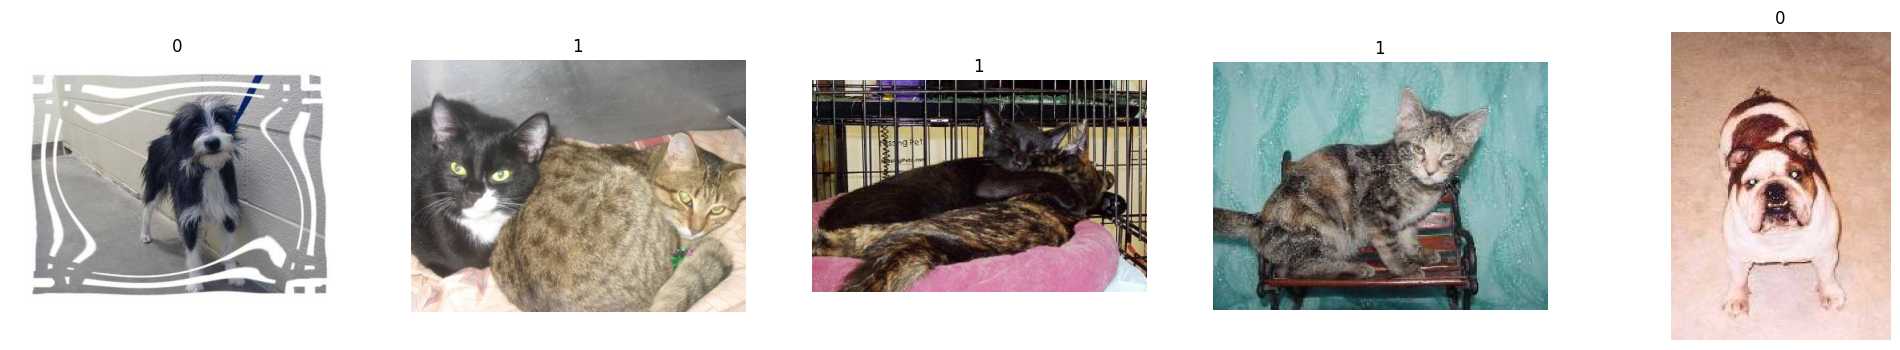

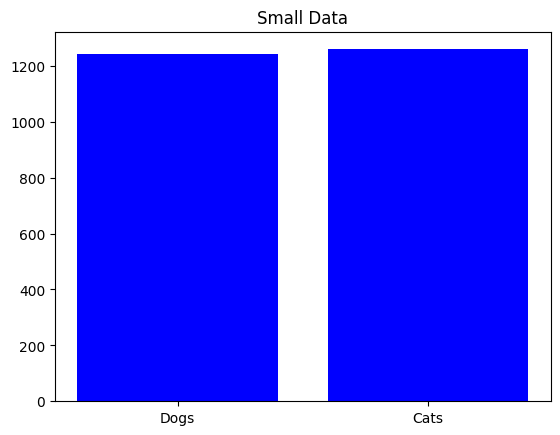

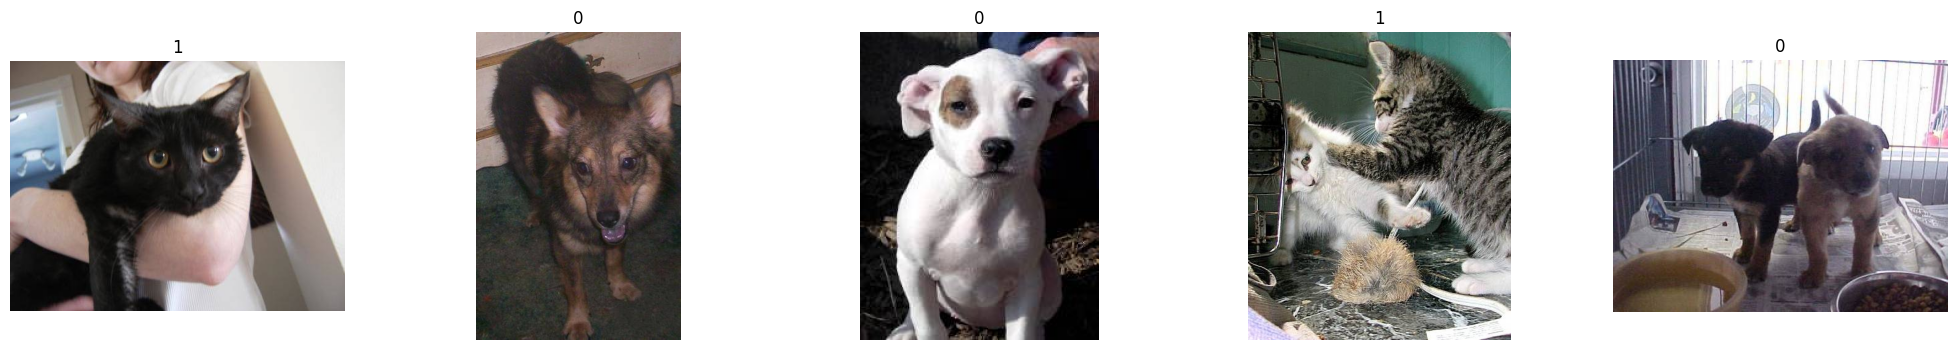

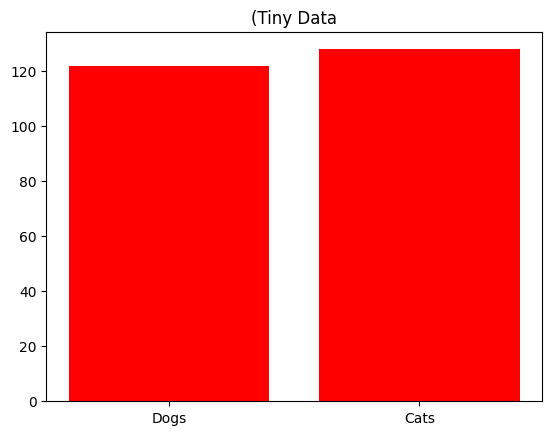

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from PIL import Image
import random

small_data = Path("experiment_small_data") 
tiny_data = Path("experiment_tiny_data") 

def load_data(dataset_path):
    images = []
    labels = []
    for image_path in dataset_path.rglob("*.jpg"):
        img = Image.open(image_path)
        images.append(np.array(img))
        
        label = 0 if "dog" in image_path.name.lower() else 1
        labels.append(label)

    combined = list(zip(images, labels))
    random.shuffle(combined)
    return combined

data_small = load_data(small_data)

fig, axes = plt.subplots(1, 5, figsize=(25, 4))
for i, (img, label) in enumerate(data_small[:5]):
    axes[i].imshow(img)
    axes[i].set_title(label)  
    axes[i].axis("off")
plt.show()

y_train_small = [label for _, label in data_small]
plt.figure()
plt.hist(y_train_small, bins=[-0.5, 0.5, 1.5], color="blue", rwidth=0.8)
plt.xticks([0, 1], ["Dogs", "Cats"])
plt.title("Small Data")
plt.show()

data_tiny = load_data(tiny_data)

fig, axes = plt.subplots(1, 5, figsize=(25, 4))
for i, (img, label) in enumerate(data_tiny[:5]):
    axes[i].imshow(img)
    axes[i].set_title(label)  
    axes[i].axis("off")
plt.show()

y_train_tiny = [label for _, label in data_tiny]
plt.figure()
plt.hist(y_train_tiny, bins=[-0.5, 0.5, 1.5], color="red", rwidth=0.8)
plt.xticks([0, 1], ["Dogs", "Cats"])
plt.title("(Tiny Data")
plt.show()


---
# 1. Bildbehandling (*)
Uppgifterna nedan ska upprepas för respektive experimentdataset om du också väljer att arbeta med
tinydatasetet.

 a) Skapa en plot för att visualisera bildstorlekarna i träningsdatan. Använd seaborns jointplot.

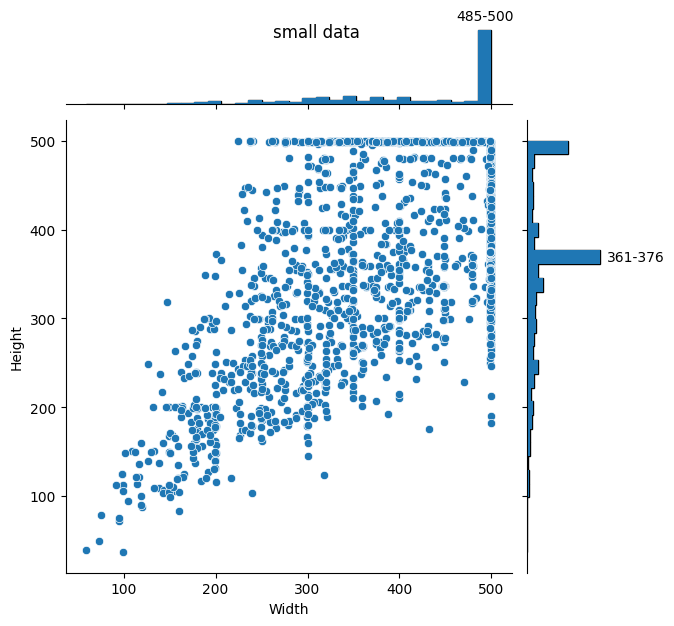

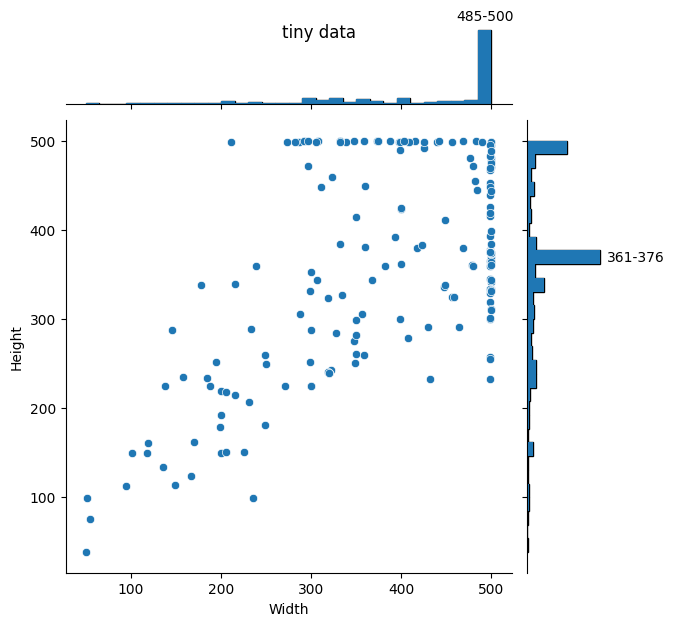

In [39]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.image import imread

def get_image_sizes(data_path):
    """Gather image dimensions for images in the specified directory."""
    sizes = []
    categories = ['train', 'val', 'test']
    for category in categories:
        cat_dir = data_path / category
        files = list(cat_dir.glob("*"))
        for image_path in files:
            img = imread(str(image_path))
            if len(img.shape) == 3:
                height, width, _ = img.shape
                sizes.append((width, height))
    return sizes

def plot_image_sizes(sizes, title):
    """Plot the image sizes using a jointplot and annotate the highest histogram bars with bin range."""
    widths, heights = zip(*sizes)
    widths = np.array(widths)
    heights = np.array(heights)

    # Create jointplot
    joint_plot = sns.jointplot(x=widths, y=heights, kind='scatter', marginal_kws=dict(bins=30, fill=True))
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.suptitle(title)

    # Annotate the highest bar in the x histogram
    n, bins, patches = joint_plot.ax_marg_x.hist(widths, bins=30, fill=True)
    max_idx = np.argmax(n)
    max_bin_start = bins[max_idx]
    max_bin_end = bins[max_idx + 1]
    joint_plot.ax_marg_x.annotate(f'{int(max_bin_start)}-{int(max_bin_end)}', xy=((max_bin_start + max_bin_end) / 2, max(n)), xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')

    # Annotate the highest bar in the y histogram
    n, bins, patches = joint_plot.ax_marg_y.hist(heights, bins=30, fill=True, orientation='horizontal')
    max_idx = np.argmax(n)
    max_bin_start = bins[max_idx]
    max_bin_end = bins[max_idx + 1]
    joint_plot.ax_marg_y.annotate(f'{int(max_bin_start)}-{int(max_bin_end)}', xy=(max(n), (max_bin_start + max_bin_end) / 2), xytext=(5, 0), textcoords='offset points', ha='left', va='center')

    plt.show()

# Setup paths
experiment_small_data = Path("experiment_small_data")
experiment_tiny_data = Path("experiment_tiny_data")

# Get sizes from each dataset
image_sizes_small = get_image_sizes(experiment_small_data)
image_sizes_tiny = get_image_sizes(experiment_tiny_data)

# Generate plots with annotations
plot_image_sizes(image_sizes_small, "small data ")
plot_image_sizes(image_sizes_tiny, "tiny data")


---
 b) Välj en lämplig bildstorlek att ändra samtliga bilder till. Gör en analys och fundera på om du behöver
slänga bilder. Hur kommer du fram till ditt val?

---
  c) Gör resize sådant att samtliga bilder är samma storlek och spara dem i numpy arrays med följande
struktur:

In [40]:
"""
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from PIL import Image
import random

def resize_images_to_array(image_folder, target_size=(224, 224)):
    image_files = [file for file in Path(image_folder).glob('*') if file.suffix.lower() in ['.png', '.jpg', '.jpeg']]
    print(f"Found {len(image_files)} images in {image_folder}")  # Debug: log found files
    images = []

    for image_file in image_files:
        print(f"Processing image: {image_file}") 
        img = Image.open(image_file)
        img = img.resize(target_size, Image.Resampling.LANCZOS)  
        if img.mode != 'RGB':
            img = img.convert('RGB')  
        img_array = np.array(img)
        images.append(img_array)

    return np.array(images)

def display_images(images, num_images=4):
    if images.size == 0:
        print("No images to display.")
        return
    
    if images.shape[0] < num_images:
        num_images = images.shape[0]
    indices = random.sample(range(images.shape[0]), num_images)
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    if num_images == 1:
        axes = [axes] 
    for i, ax in enumerate(axes):
        ax.imshow(images[indices[i]])
        ax.axis('off')
    plt.show()

small_data = Path("experiment_small_data/train")
tiny_data = Path("experiment_tiny_data/train")

# Process the images in each directory
small_data_images = resize_images_to_array(small_data)
tiny_data_images = resize_images_to_array(tiny_data)

print("Small Data Images:")
display_images(small_data_images)

print("Tiny Data Images:")
display_images(tiny_data_images) """


'\nimport matplotlib.pyplot as plt\nimport numpy as np\nfrom pathlib import Path\nfrom PIL import Image\nimport random\n\ndef resize_images_to_array(image_folder, target_size=(224, 224)):\n    image_files = [file for file in Path(image_folder).glob(\'*\') if file.suffix.lower() in [\'.png\', \'.jpg\', \'.jpeg\']]\n    print(f"Found {len(image_files)} images in {image_folder}")  # Debug: log found files\n    images = []\n\n    for image_file in image_files:\n        print(f"Processing image: {image_file}") \n        img = Image.open(image_file)\n        img = img.resize(target_size, Image.Resampling.LANCZOS)  \n        if img.mode != \'RGB\':\n            img = img.convert(\'RGB\')  \n        img_array = np.array(img)\n        images.append(img_array)\n\n    return np.array(images)\n\ndef display_images(images, num_images=4):\n    if images.size == 0:\n        print("No images to display.")\n        return\n    \n    if images.shape[0] < num_images:\n        num_images = images.shape[0]

---
 d) Augmentera datan. Varför behövs dataaugmentering och hur beslutar du vilka parametrar du valt för
augmenteringen

Exempel på parametrar för bilddataaugmentering kan inkludera:

    Rotation: Bilden roteras med ett slumpmässigt vinkel.
    Skalning: Bildstorleken ändras genom zoomning in och ut.
    Horisontell/Vertikal spegling: Bilden speglas horisontellt eller vertikalt.
    Färgjustering: Ändringar i ljusstyrka, kontrast, mättnad, och nyans.

Starting augmentation...
Augmented Small Data Images:


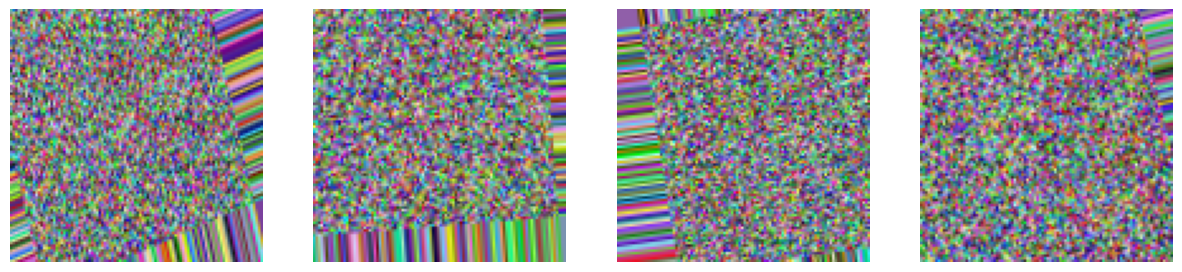

Starting augmentation...
Augmented Tiny Data Images:


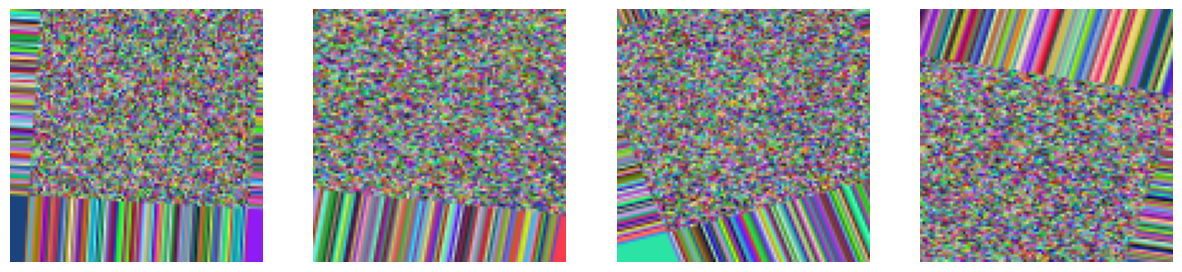

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to display random images
def display_random_images(images, num_images=4):
    if images.size == 0:
        print("No images to display.")
        return
    
    if images.shape[0] < num_images:
        num_images = images.shape[0]

    # Normalize image data to 0-1 for proper imshow display
    images = images.astype('float32') / 255.0

    # Select random indices
    random_indices = random.sample(range(images.shape[0]), num_images)
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    if num_images == 1:
        axes = [axes]  # Make sure axes is always a list for consistent indexing
    for i, ax in zip(random_indices, axes):
        ax.imshow(images[i])  # Accessing images by random index
        ax.axis('off')
    plt.show()

# Function to create ImageDataGenerator
def create_data_generator():
    # Creating an instance of ImageDataGenerator with some common augmentations
    data_gen = ImageDataGenerator(
        rotation_range=20,       # random rotations from 0 to 20 degrees
        width_shift_range=0.2,   # random horizontal shifts
        height_shift_range=0.2,  # random vertical shifts
        shear_range=0.15,        # random shearing transformation
        zoom_range=0.2,          # random zoom
        horizontal_flip=True,    # random horizontal flips
        fill_mode='nearest'      # strategy for filling newly created pixels
    )
    return data_gen

# Function to apply augmentation
def augment_images(images, data_gen, batch_size=32):
    print("Starting augmentation...")
    # Create a flow from the images for real-time data augmentation
    flow = data_gen.flow(images, batch_size=batch_size)
    augmented_images = next(flow)  # Get a batch of augmented images
    return augmented_images

# Function to display images
def display_images(images, num_images=4):
    if images.size == 0:
        print("No images to display.")
        return
    
    if images.shape[0] < num_images:
        num_images = images.shape[0]

    # Normalize image data to 0-1 for proper imshow display
    images = images.astype('float32') / 255.0
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    if num_images == 1:
        axes = [axes]  # Make sure axes is always a list for consistent indexing
    for i, ax in enumerate(axes):
        ax.imshow(images[i])  # Accessing images directly by index
        ax.axis('off')
    plt.show()

# Generate some sample data
small_data_images = np.random.randint(0, 255, (10, 100, 100, 3), dtype=np.uint8)
tiny_data_images = np.random.randint(0, 255, (5, 100, 100, 3), dtype=np.uint8)

# Creating the data generator
data_gen = create_data_generator()

# Augment the small dataset images
augmented_small_data_images = augment_images(small_data_images, data_gen)
print("Augmented Small Data Images:")
display_random_images(augmented_small_data_images)

# Augment the tiny dataset images
augmented_tiny_data_images = augment_images(tiny_data_images, data_gen)
print("Augmented Tiny Data Images:")
display_random_images(augmented_tiny_data_images)
